# Counting *n*-grams

We develop a simple language model based on *n*-grams.

In [1]:
from chapter import *

In [2]:
%%save
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

FRAC_LIMIT = 0.3
PAD_TOKEN = "."

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")

import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

FRAC_LIMIT = 0.3
PAD_TOKEN = "."

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")

Getting the dataset:

In [3]:
import os
if not os.path.isfile("./data/surnames_freq_ge_100.csv"):
    !wget -O ./data/surnames_freq_ge_100.csv https://raw.githubusercontent.com/particle1331/spanish-names-surnames/master/surnames_freq_ge_100.csv
    !wget -O ./data/surnames_freq_ge_20_le_99.csv https://raw.githubusercontent.com/particle1331/spanish-names-surnames/master/surnames_freq_ge_20_le_99.csv
else:
    print("Data files already exist.")

Data files already exist.


Loading and preprocessing into a list of strings:

In [4]:
%%save
def load_surnames(frac: float = FRAC_LIMIT, min_len=2) -> list[str]:
    """Load shuffled surnames from files into a list."""

    col = ["surname", "frequency_first", "frequency_second", "frequency_both"]
    filepaths = ["surnames_freq_ge_100.csv", "surnames_freq_ge_20_le_99.csv"]
    dfs = [pd.read_csv(DATASET_DIR / f, names=col, header=0) for f in filepaths]
    df = pd.concat(dfs, axis=0)[["surname"]].sample(frac=frac)
    df = df.reset_index(drop=True)
    df["surname"] = df["surname"].map(lambda s: s.lower())
    df["surname"] = df["surname"].map(lambda s: s.replace("de la", "dela"))
    df["surname"] = df["surname"].map(lambda s: s.replace(" ", "_"))
    df = df[["surname"]].dropna().astype(str)

    names = [
        n for n in df.surname.tolist() 
        if ("'" not in n) and ('ç' not in n) and (len(n) >= min_len)
    ]
    
    return names

def load_surnames(frac: float = FRAC_LIMIT, min_len=2) -> list[str]:
    """Load shuffled surnames from files into a list."""

    col = ["surname", "frequency_first", "frequency_second", "frequency_both"]
    filepaths = ["surnames_freq_ge_100.csv", "surnames_freq_ge_20_le_99.csv"]
    dfs = [pd.read_csv(DATASET_DIR / f, names=col, header=0) for f in filepaths]
    df = pd.concat(dfs, axis=0)[["surname"]].sample(frac=frac)
    df = df.reset_index(drop=True)
    df["surname"] = df["surname"].map(lambda s: s.lower())
    df["surname"] = df["surname"].map(lambda s: s.replace("de la", "dela"))
    df["surname"] = df["surname"].map(lambda s: s.replace(" ", "_"))
    df = df[["surname"]].dropna().astype(str)

    names = [
        n for n in df.surname.tolist() 
        if ("'" not in n) and ('ç' not in n) and (len(n) >= min_len)
    ]
    
    return names

In [5]:
names = load_surnames()
for j in range(5):
    print(names[j])

durana
dela_azuela
atlassi
irulegi
stockwell


We will tokenize the names at the character level:

In [6]:
from collections import Counter

name_lengths = Counter([len(n) for n in names])
corpus = "".join(names)
print("num chars:  ", len(set(corpus)))
print("total names:", len(names))
print("total chars:", len(corpus))

num chars:   28
total names: 22136
total chars: 164611


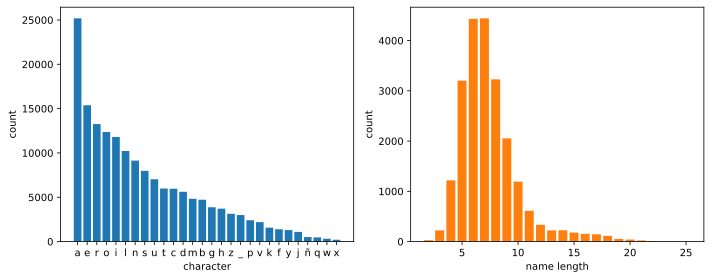

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vocab = Vocab(corpus, preprocess=False)
ax[0].bar(x=[tok for tok, _ in vocab.token_freqs], height=[freq for _, freq in vocab.token_freqs])
ax[0].set_xlabel("character", fontsize=10)
ax[0].set_ylabel("count", fontsize=10)

ax[1].set_xlabel("name length")
ax[1].set_ylabel("count")
ax[1].bar(name_lengths.keys(), name_lengths.values(), color="C1")

fig.tight_layout();

Spanish surnames have median name length 7 (counting space):

In [8]:
print("range: ", [min(name_lengths.keys()), max(name_lengths.keys())])
print("median: ", int(np.median(sorted([len(n) for n in names]))))

range:  [2, 25]
median:  7


Defining the dataset of context-target pairs. These are constructed by iterating with a window of fixed size over each name to get
$(\boldsymbol{\mathsf{x}}_{i}, \ldots, \boldsymbol{\mathsf{x}}_{i + c - 1}) \mapsto \boldsymbol{\mathsf{x}}_c$ pairs where $i$ is the index and $c$ is the block size. Moreover, each name is padded with padding `.` indicating the start and end of a name, e.g. `"...durana."` for context size 3. Note that all inputs have the same size.

In [9]:
%%save
import torch
from typing import List
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, 
        names: List[str], 
        block_size: int,
        vocab: Optional[Vocab] = None
    ):
        self.block_size = block_size
        self.vocab = vocab or Vocab(text="".join(names), preprocess=False, reserved_tokens=[PAD_TOKEN])
        self.tokenizer = Tokenizer(self.vocab)
        self.xs, self.ys = self.samples(names)

    def vocab_size(self):
        return len(self.vocab)
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, i: int):
        x = self.tokenizer.encode(self.xs[i])
        y = self.tokenizer.encode(self.ys[i])[0]
        return x, y

    def samples(self, names: List[str]):
        xs, ys = [], []
        for name in names:
            context = PAD_TOKEN * self.block_size
            for c in name + PAD_TOKEN:
                xs.append(context)
                ys.append(c)
                context = context[1:] + c
        return xs, ys

import torch
from typing import List
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, 
        names: List[str], 
        block_size: int,
        vocab: Optional[Vocab] = None
    ):
        self.block_size = block_size
        self.vocab = vocab or Vocab(text="".join(names), preprocess=False, reserved_tokens=[PAD_TOKEN])
        self.tokenizer = Tokenizer(self.vocab)
        self.xs, self.ys = self.samples(names)

    def vocab_size(self):
        return len(self.vocab)
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, i: int):
        x = self.tokenizer.encode(self.xs[i])
        y = self.tokenizer.encode(self.ys[i])[0]
        return x, y

    def samples(self, names: List[str]):
        xs, ys = [], []
        for name in names:
            context = PAD_TOKEN * self.block_size
            for c in name + PAD_TOKEN:
                xs.append(context)
                ys.append(c)
                context = context[1:] + c
        return xs, ys

Using this we can create sequence datasets of any **fixed** context size to predict the next character:

In [10]:
dataset = CharDataset(names, block_size=3)
x, y = zip(*[dataset[i] for i in range(7)])
pd.DataFrame({"xs": dataset.xs[:7], "ys": dataset.ys[:7], "x": list(map(lambda e: e.tolist(), x)), "y": list(map(lambda e: e.item(), y))})

,xs,ys,x,y
0,...,d,"[1, 1, 1]",13
1,..d,u,"[1, 1, 13]",10
2,.du,r,"[1, 13, 10]",4
3,dur,a,"[13, 10, 4]",2
4,ura,n,"[10, 4, 2]",8
5,ran,a,"[4, 2, 8]",2
6,ana,.,"[2, 8, 2]",1


<br>

## Frequency table

Bigrams are essentially input-output pairs with context size 1. The following constructs the table of character bigrams appearing in names in the training dataset. An entry `[i, j]` in the array below is the count of bigrams that start with the `i`th character followed by the `j`th character. We also consider padding.

In [11]:
split_point = int(0.80 * len(names))
names_train = names[:split_point]
names_valid = names[split_point:]
vocab = Vocab(text="".join(names), preprocess=False, reserved_tokens=[PAD_TOKEN])
bigram_train = CharDataset(names_train, block_size=1, vocab=vocab)
bigram_valid = CharDataset(names_valid, block_size=1, vocab=vocab)

# count matrix
n = bigram_train.vocab_size()
N2 = torch.zeros((n, n), dtype=torch.int32)
for x, y in bigram_train:
    N2[x[0].item(), y.item()] += 1

**Remark.** Note that we use one vocabulary for training and validation (i.e. combined). 

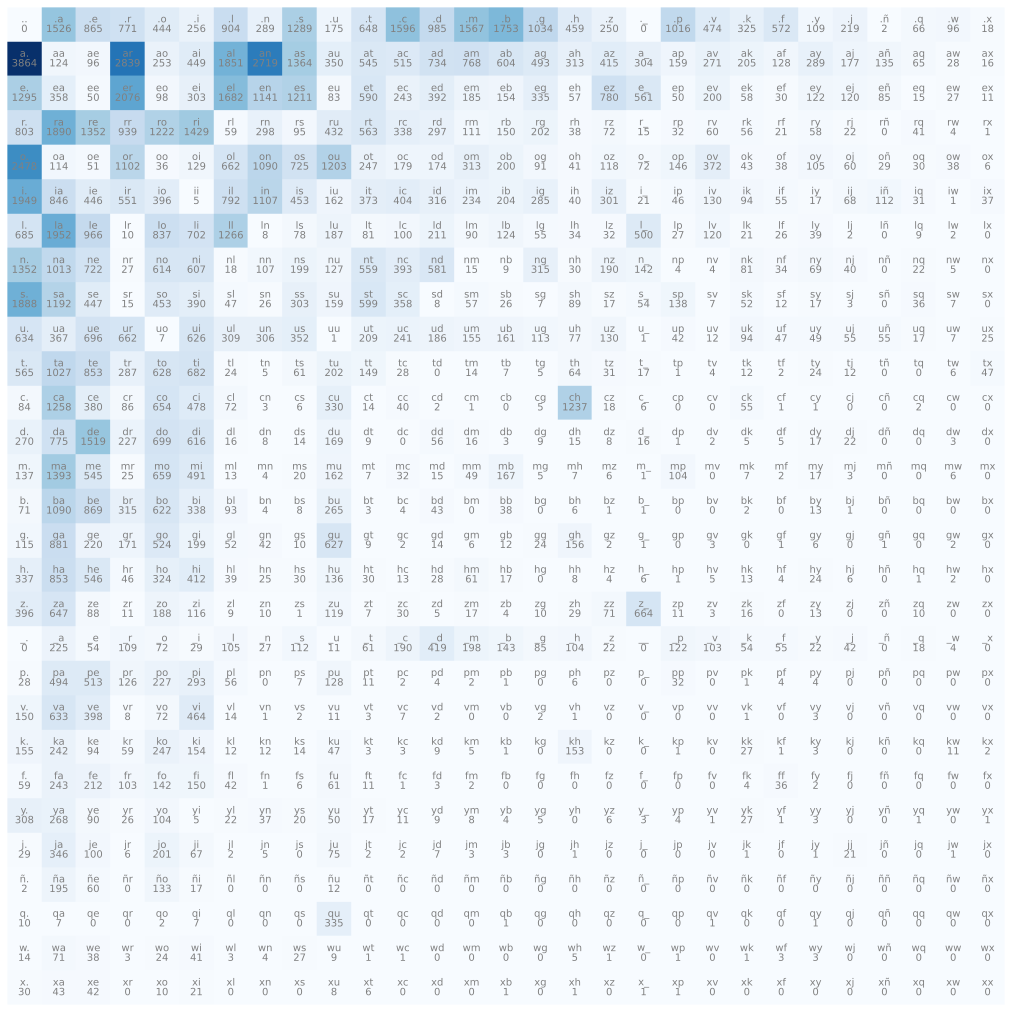

In [12]:
# viz (ignore <unk>)
plt.figure(figsize=(18, 18))
plt.imshow(N2[1:, 1:], cmap='Blues')
for i in range(N2.shape[0] - 1):
    for j in range(N2.shape[1] - 1):
        chstr = bigram_train.tokenizer.decode(i + 1) + bigram_train.tokenizer.decode(j + 1)
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N2[1:, 1:][i, j].item(), ha="center", va="top", color="gray")

plt.axis("off");

**Remark.** The count table for general *n*-grams is a $| \mathcal{V} |^n$ matrix. But by Zipf's law, this matrix becomes increasingly sparse with increasing *n*.

<br>

## Modeling counts

The above frequency table can be constructed with $n$-grams, in general. A context $\boldsymbol{\mathsf{x}}$ represented as an $n - 1$ tuple can be used to index the frequency table to get the frequency distribution for the target token. The model outputs the distribution $f(\boldsymbol{\mathsf{x}}) = p(\cdot \mid \boldsymbol{\mathsf{x}})$ by normalizing and smoothing the counts.

In [13]:
%%save
class CountingModel:
    def __init__(self, block_size: int, vocab_size: int, alpha=0.01):
        """Model of observed n-grams to estimate next char probability."""
        self.P = None                    # cond. prob
        self.N = None                    # counts
        self.alpha = alpha               # laplace smoothing
        self.block_size = block_size
        self.vocab_size = vocab_size

    def __call__(self, x: torch.tensor) -> torch.tensor:
        # tuple(x.T) = ([x11, x21, x31], [x12, x22, x32]) 
        # i.e. len = block_size, num entries = B
        # then, P[tuple(x.T)][b] == P[xb1, xb2], so output has shape (B, vocab_size) 
        return torch.tensor(self.P[tuple(x.T)])    

    def fit(self, dataset: CharDataset):
        v = self.vocab_size
        n = self.block_size + 1     # +1 for output dim
        self.N = torch.zeros([v] * n, dtype=torch.int32)  
        for x, y in dataset:
            self.N[tuple(x)][y] += 1

        a = self.alpha
        self.P = (self.N + a)/ (self.N + a).sum(dim=-1, keepdim=True)

    def evaluate(self, dataset: CharDataset):
        loss = 0.0
        for x, y in dataset:
            loss += -torch.log(self(x[None, :])[0, y]).item()
        return loss / len(dataset)

class CountingModel:
    def __init__(self, block_size: int, vocab_size: int, alpha=0.01):
        """Model of observed n-grams to estimate next char probability."""
        self.P = None                    # cond. prob
        self.N = None                    # counts
        self.alpha = alpha               # laplace smoothing
        self.block_size = block_size
        self.vocab_size = vocab_size

    def __call__(self, x: torch.tensor) -> torch.tensor:
        # tuple(x.T) = ([x11, x21, x31], [x12, x22, x32]) 
        # i.e. len = block_size, num entries = B
        # then, P[tuple(x.T)][b] == P[xb1, xb2], so output has shape (B, vocab_size) 
        return torch.tensor(self.P[tuple(x.T)])    

    def fit(self, dataset: CharDataset):
        v = self.vocab_size
        n = self.block_size + 1     # +1 for output dim
        self.N = torch.zeros([v] * n, dtype=torch.int32)  
        for x, y in dataset:
            self.N[tuple(x)][y] += 1

        a = self.alpha
        self.P = (self.N + a)/ (self.N + a).sum(dim=-1, keepdim=True)

    def evaluate(self, dataset: CharDataset):
        loss = 0.0
        for x, y in dataset:
            loss += -torch.log(self(x[None, :])[0, y]).item()
        return loss / len(dataset)

Fitting a bigram model which has a context of one character: 

In [14]:
vocab = Vocab(text="".join(names), preprocess=False, reserved_tokens=[PAD_TOKEN])
bigram_train = CharDataset(names_train, block_size=1, vocab=vocab)
bigram_valid = CharDataset(names_valid, block_size=1, vocab=vocab)

bigram_model = CountingModel(block_size=1, vocab_size=len(vocab))
bigram_model.fit(bigram_train)
bigram_model.evaluate(bigram_valid)

2.510331458524424

The learned conditional probabilities can be visualized for the bigram model:

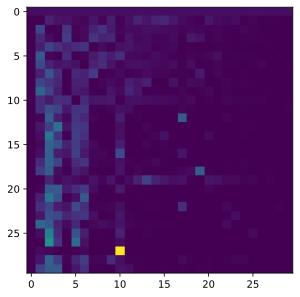

In [15]:
plt.imshow(bigram_model.P);    # yellow pixel is for “qu” ☺

Similarly, we can fit a trigram model as follows:

In [16]:
trigram_train = CharDataset(names_train, block_size=2, vocab=vocab)
trigram_valid = CharDataset(names_valid, block_size=2, vocab=vocab)
trigram_model = CountingModel(block_size=2, vocab_size=len(vocab))
trigram_model.fit(trigram_train)

# Sample prediction and evals
p = trigram_model(torch.tensor([[1, 1], [2, 2]]))
print(p.shape, p.sum(dim=1).view(-1))
print(trigram_model.evaluate(trigram_train))
print(trigram_model.evaluate(trigram_valid))

torch.Size([2, 30]) tensor([1.0000, 1.0000])
2.267962301462323
2.3533043515255345


Both models are better than random:

In [17]:
import math
math.log(len(vocab) - 2)    # -2 for <unk> and padding

3.332204510175204

Note that already at $n = 3$ generalization starts to drop:

In [18]:
ngram_train = CharDataset(names_train, block_size=3, vocab=vocab)
ngram_valid = CharDataset(names_valid, block_size=3, vocab=vocab)
ngram_model = CountingModel(block_size=3, vocab_size=len(vocab))
ngram_model.fit(ngram_train)

# Sample prediction and evals
print(ngram_model.evaluate(ngram_train))
print(ngram_model.evaluate(ngram_valid))

1.9255481190171766
2.4070117212841913


<br>

## Generating names

For concreteness, we will consider a trigram model. First, a character is sampled from a [multinomial distribution](https://online.stat.psu.edu/stat504/book/export/html/667)[^1] given the start context `..`. The context is appended with each sampled character, say `e`. Since our trigram model only uses the last 2 characters, the relevant context becomes `.e`. This is repeated until another `.` is sampled, signaling the end of a name.

[^1]: Independent samples with $|\mathcal{V}|$ mutually exclusive outcomes, one for each character.

In [19]:
%%save
def generate_name(
    model, 
    dataset: CharDataset, 
    min_len=2,
    max_len=100, 
    g=None, seed=2718
):
    """Generate names from a Markov process with cond prob from model."""
    if g is None:
        g = torch.Generator().manual_seed(seed)
    
    context = PAD_TOKEN * dataset.block_size
    out = []
    while len(context) < max_len:
        x = dataset.tokenizer.encode(context).view(1, -1)
        p = model(x)[0]
        j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        c = dataset.tokenizer.decode(j)
        if c == PAD_TOKEN:
            if len(out) >= min_len:
                break
            else:
                continue
        
        out.append(c)
        context = context[1:] + c
    
    return "".join(out)

def generate_name(
    model, 
    dataset: CharDataset, 
    min_len=2,
    max_len=100, 
    g=None, seed=2718
):
    """Generate names from a Markov process with cond prob from model."""
    if g is None:
        g = torch.Generator().manual_seed(seed)
    
    context = PAD_TOKEN * dataset.block_size
    out = []
    while len(context) < max_len:
        x = dataset.tokenizer.encode(context).view(1, -1)
        p = model(x)[0]
        j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        c = dataset.tokenizer.decode(j)
        if c == PAD_TOKEN:
            if len(out) >= min_len:
                break
            else:
                continue
        
        out.append(c)
        context = context[1:] + c
    
    return "".join(out)

Sampling based on bigram counts:

In [20]:
g = torch.Generator().manual_seed(0)
for i in range(10):
    print(generate_name(bigram_model, bigram_train, min_len=3, max_len=60, g=g))

pelaza
trogrgoson_qussata
bularockelaya
nousabeganderamiledous
marezuz
frdedhadaileon
caraalugurenujao
ndertye
cia
dancial


Sampling based on trigram counts seem to have better results:

In [21]:
g = torch.Generator().manual_seed(0)
for i in range(10):
    print(generate_name(trigram_model, trigram_train, min_len=3, max_len=60, g=g))

pelaza
torogbomez_de_santa
bulcarci
layo
nabonesabentelardalledouguichez
piniñedhamaillon
caraalugerowskao
nov
tre
caridancial
